In [1]:
import numpy as np
import igraph as ig
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy
import mean_wrapper as mw
from GmGM import Dataset, GmGM
from mean_wrapper import kron_sum, vec_kron_sum
import mean_wrapper as mw
import random

SEED = 0

# Make palette colorblind friendly
plt.style.use('tableau-colorblind10')
hatches = ['|', '//', 'oo', 'x', '+', '-', 'OO', '.', '*', '\\']
lines = ['-', '--', '-.', ':', (0, (3, 5, 1, 5, 1, 5))]

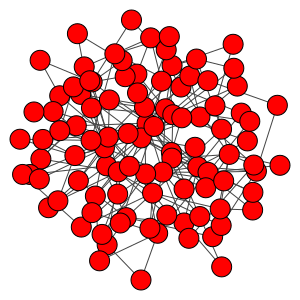

In [2]:
random.seed(SEED)
graph = ig.Graph.Barabasi(100, 2)

# Display graph
ig.plot(graph, bbox=(0, 0, 300, 300))

In [3]:
random.seed(SEED)
num_nodes = 5
graph = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)
adj_mat = np.array(graph.get_adjacency().data)

# Add diagonal so that it forms a PSD matrix!
adj_mat = adj_mat / 1.1 + np.eye(num_nodes)

display(adj_mat)
display(kron_sum([adj_mat, adj_mat]).toarray())

array([[1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.90909091, 0.        , 0.        ],
       [0.        , 0.90909091, 1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        , 0.90909091],
       [0.        , 0.        , 0.        , 0.90909091, 1.        ]])

array([[2.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 2.        , 0.90909091, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.90909091, 2.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.

In [4]:
def fast_kronecker_normal(
    Psis: list[np.ndarray],
    size: int,
    fail_if_not_posdef: bool = False,
    mean: np.array = None,
) -> np.ndarray:
    """
    Inputs:
        Psis: List of (d_i, d_i) precision matrices, of length K >= 2
        size: Number of samples
        fail_if_not_posdef:
            If True, raise Exception if any of the Psis is not positive definite
        mean: Mean of the distribution

    Outputs:
        Xs: Sample of Kronecker sum structured normal distribution
    """


    K = len(Psis)
    ds = [Psi.shape[0] for Psi in Psis]
    vs, Vs = zip(*[np.linalg.eigh(Psi) for Psi in Psis])
    diag_precisions = vec_kron_sum(vs)
    
    # Check if positive definite
    min_diag = diag_precisions.min()
    if min_diag < 0:
        if fail_if_not_posdef:
            raise Exception("KS of Psis not Positive Definite")
        diag_precisions -= (min_diag-1)
    
    # Sample from diagonalized, vectorized distribution
    z = stats.multivariate_normal(cov=1).rvs(
        size=size*np.prod(ds)
    ).reshape(size, np.prod(ds)) / np.sqrt(diag_precisions)
    
    # Reshape into a tensor
    Xs: np.ndarray = z.reshape(size, *ds)
    
    # Undiagonalize the distribution
    for k in range(K):
        Xs = np.moveaxis(
            np.moveaxis(Xs, k+1, -1) @ Vs[k].T,
            -1,
            k+1
        )

    if mean is not None:
        Xs += mean.reshape(1, *ds)

    return Xs

In [5]:
def pr_curve(
    ground_truth: np.ndarray,
    output: np.ndarray,
    num_points: int = 1000
) -> tuple[np.ndarray, np.ndarray]:
    """
    Inputs:
        ground_truth: Adjacency matrix of graph
        output: Output of algorithm
        num_points: Number of points to sample

    Outputs:
        (precisions, recalls): Precision-recall curve
    """
    # Setup
    precisions = np.zeros(num_points)
    recalls = np.zeros(num_points)
    thresholds = np.linspace(0, np.max(output), num_points)

    ground_truth = ground_truth != 0
    np.fill_diagonal(ground_truth, 0)

    # Iterate over thresholds
    for i, threshold in enumerate(thresholds):
        # Threshold output
        output_thresholded = (output > threshold).astype(int)
        np.fill_diagonal(output_thresholded, 0)

        # Calculate precision and recall
        true_positives = np.sum(output_thresholded * ground_truth)
        false_positives = np.sum(output_thresholded * (1 - ground_truth))
        false_negatives = np.sum((1 - output_thresholded) * ground_truth)

        if true_positives + false_positives == 0:
            precisions[i] = 1
            recalls[i] = 0
        else:
            precisions[i] = true_positives / (true_positives + false_positives)
            recalls[i] = true_positives / (true_positives + false_negatives)

    return precisions, recalls

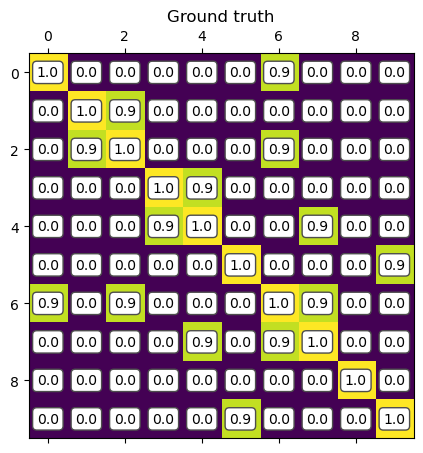

In [6]:
random.seed(SEED)
np.random.seed(SEED)

# Create a random graph
num_nodes = 10
graph = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)
ground_truth = np.array(graph.get_adjacency().data)
ground_truth = ground_truth / 1.1 + np.eye(num_nodes)

fig, ax1 = plt.subplots(ncols=1, figsize=(10, 5))
ax1.matshow(ground_truth)
ax1.set_title("Ground truth")

for (i, j), z in np.ndenumerate(ground_truth):
    ax1.text(
        j,
        i,
        '{:0.1f}'.format(z),
        ha='center',
        va='center',
        bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3')
    )

# Run Experiments

Running GmGM
	Trial 0 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:229: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
Running GmGM + mean estimation
	Trial 0 of 10
Iteration: 1 (Change: 44.907621444636135)
Iteration: 2 (Change: 98.29481474354967)
Iteration: 3 (Change: 0.28069727282391815)
Iteration: 4 (Change: 0.001183397768465341)
Converged in 5 iterations
Iteration: 5 (Change: 5.950564958995796e-05)
	Trial 1 of 10
Iteration: 1 (Change: 44.907623020986016)
Iteration: 2 (Change: 98.2595837604722)
Iteration: 3 (Change: 0.26159486400634546)
Iteration: 4 (Change: 0.008537261782556685)
Converged in 5 iterations
Iteration: 5 (Change: 6.415745784652614e-05)
	Trial 2 of 10
Iteration: 1 (Change: 44.907621892927125)
Iteration: 2 (Change: 98.28117547691929)
Iteration: 3 (Change: 0.3273312869009609)
Iteration: 4 (Change: 0.0015029201484947788)
Converged in 5 iterations
Iteration: 5 (Change: 6.249649329432448e-05)
	Trial 3 of 10
Iteration: 1 (Change: 44.90762177775368)
Iteration: 

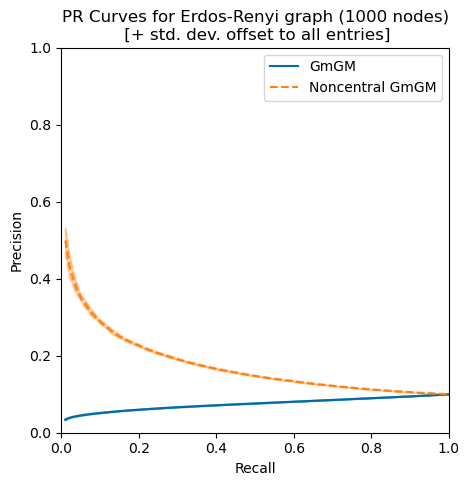

In [22]:
random.seed(SEED)
np.random.seed(SEED)

# Create a random graph
num_nodes = 1000
graph = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)
ground_truth = np.array(graph.get_adjacency().data)
colors = ["blue", "green"]

# Add diagonal so that it forms a PSD matrix!
ground_truth = ground_truth / 1.1 + np.eye(num_nodes)

fig, ax1 = plt.subplots(ncols=1, figsize=(5, 5))


algorithms = (
    [
        "GmGM",
        "GmGM + mean estimation",
        #"GmGM + nonparanormal",
        #"TeraLasso",
    ]
)
for idx, algorithm in enumerate(algorithms):
    print(f"Running {algorithm}")
    ps = []
    rs = []


    # Create a fake output
    num_trials = 10
    for i in range(num_trials):
        print(f"\tTrial {i} of {num_trials}")

        # Generate data
        output = fast_kronecker_normal(
            [ground_truth, ground_truth],
            1
        )
        # Add total mean offset
        standard_dev = 1 / np.sqrt(2 * (ground_truth[0, 0]))
        output += standard_dev

        # Add axis-wise offset
        #output += not here

        dataset = Dataset(
            dataset={"data": output},
            structure={"data": ("", "rows", "columns")}
        )
        result = None
        if algorithm == "GmGM":
            result = GmGM(
                dataset,
                to_keep=1,
                threshold_method="overall-col-weighted",
                min_edges={"rows": num_nodes - 1, "columns": num_nodes - 1},
                n_comps=None,
                verbose=False,
                centering_method=None,
                use_nonparanormal_skeptic=False,
                nonparanormal_evec_backend="COCA",
                readonly=False,
                calculate_explained_variance=True,
                batch_size=1000
            )
        elif algorithm == "GmGM + nonparanormal":
            result = GmGM(
                dataset,
                to_keep=1,
                threshold_method="overall-col-weighted",
                min_edges={"rows": num_nodes - 1, "columns": num_nodes - 1},
                n_comps=None,
                verbose=False,
                centering_method=None,
                use_nonparanormal_skeptic=True,
                nonparanormal_evec_backend="COCA",
                readonly=False,
                calculate_explained_variance=True,
                batch_size=1000
            )
        elif algorithm == "GmGM + mean estimation":
            def gmgm_estimator(data):
                output = GmGM(
                    dataset,
                    to_keep=1,
                    threshold_method="overall-col-weighted",
                    min_edges={"rows": num_nodes - 1, "columns": num_nodes - 1},
                    n_comps=None,
                    verbose=False,
                    centering_method=None,
                    use_nonparanormal_skeptic=False,
                    nonparanormal_evec_backend="COCA",
                    readonly=False,
                    calculate_explained_variance=True,
                    batch_size=1000
                )
                return output.precision_matrices
            NKS = mw.NoncentralKS(
                gmgm_estimator,
                ({axis: np.zeros(num_nodes) for axis in dataset.all_axes - dataset.batch_axes}, 0),
                {axis: np.eye(num_nodes) for axis in dataset.all_axes - dataset.batch_axes},
            )
            class result_container:
                # Jerry-rigged class to hold the result
                def __init__(self, precmats):
                    self.precision_matrices = precmats

            means, precisions = NKS.fit(dataset, verbose=True, tol=1e-3)
            result = result_container(precisions)
        elif algorithm == "TeraLasso":
            result = bg.TeraLasso(
                dataset,
                0,
                use_nonparanormal_skeptic=False
            )
        if result is None:
            raise Exception("Unknown algorithm")

        ys, xs = pr_curve(ground_truth, result.precision_matrices["columns"].toarray())
        ps.append(ys)
        rs.append(xs)
        #ax.plot(xs, ys)


    num_points = 100
    xs = np.linspace(0, 1, num_points)

    if algorithm == "GmGM":
        label = "GmGM"
    elif algorithm == "GmGM + mean estimation":
        label = "Noncentral GmGM"
    elif algorithm == "TeraLasso":
        label = "TeraLasso"
    elif algorithm == "GmGM + nonparanormal":
        label = "Nonparanormal GmGM"

    lineplot = ax1.plot(-1, -1)#, label=label)
    xs = np.linspace(0.01, 1, 100)
    min_ys = np.zeros(100) + 1
    max_ys = np.zeros(100)
    for p, r in zip(ps, rs):
        f = scipy.interpolate.interp1d(r, p, kind='linear', fill_value='extrapolate')
        min_ys = np.minimum(min_ys, f(xs))
        max_ys = np.maximum(max_ys, f(xs))
        #plt.plot(xs, f(xs), color='black', alpha=0.1)

    ax1.plot(
        xs,
        min_ys,
        color=lineplot[0].get_color(),
        linestyle=lines[idx],
        alpha=0.3
    )
    ax1.plot(
        xs,
        max_ys,
        color=lineplot[0].get_color(),
        linestyle=lines[idx],
        alpha=0.3
    )
    ax1.plot(
        xs,
        (min_ys + max_ys) / 2,
        color=lineplot[0].get_color(),
        label=label,
        linestyle=lines[idx]
    )
    ax1.fill_between(
        xs,
        min_ys,
        max_ys,
        color=lineplot[0].get_color(),
        alpha=0.3
    )#, hatch=hatches[idx]+hatches[idx])

ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title(
    f'PR Curves for Erdos-Renyi graph ({num_nodes} nodes)'
    + '\n [+ std. dev. offset to all entries]'
)
ax1.legend()


fig.savefig('./out-figs/offset-ks-pr-1000.pdf', bbox_inches="tight")
pass

Running GmGM
	Trial 0 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:229: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
Running GmGM + mean estimation
	Trial 0 of 10
Iteration: 1 (Change: 45.18470278714075)
Iteration: 2 (Change: 97.42673028197908)
Iteration: 3 (Change: 1.5911856571922387)
Converged in 4 iterations
Iteration: 4 (Change: 0.007834577936402434)
	Trial 1 of 10
Iteration: 1 (Change: 44.94561887939724)
Iteration: 2 (Change: 98.0171356790166)
Iteration: 3 (Change: 17.81849842462598)
Iteration: 4 (Change: 0.11902882653929292)
Converged in 5 iterations
Iteration: 5 (Change: 0.00037245667708635564)
	Trial 2 of 10
Iteration: 1 (Change: 44.893289201769875)
Iteration: 2 (Change: 10.864913296588373)
Iteration: 3 (Change: 90.10739171131092)
Iteration: 4 (Change: 1.8521166266018876)
Converged in 5 iterations
Iteration: 5 (Change: 0.0036842893923039115)
	Trial 3 of 10
Iteration: 1 (Change: 44.917378927867695)
Iteration: 2 (Change: 11.364501467980135)
Iteration: 3 (Change:

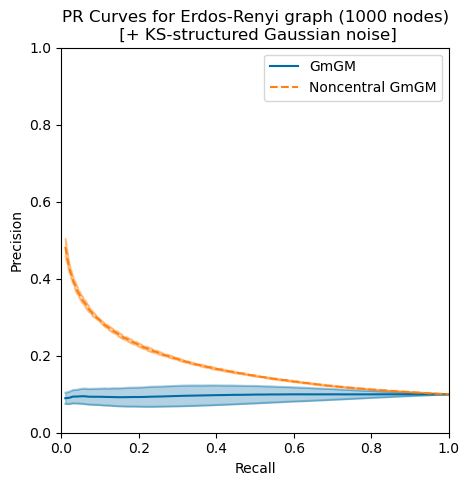

In [91]:
random.seed(SEED)
np.random.seed(SEED)

# Create a random graph
num_nodes = 1000
graph = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)
ground_truth = np.array(graph.get_adjacency().data)
colors = ["blue", "green"]

# Add diagonal so that it forms a PSD matrix!
ground_truth = ground_truth / 1.1 + np.eye(num_nodes)

fig, ax1 = plt.subplots(ncols=1, figsize=(5, 5))


algorithms = (
    [
        "GmGM",
        "GmGM + mean estimation",
        #"GmGM + nonparanormal",
        #"TeraLasso",
    ]
)
for idx, algorithm in enumerate(algorithms):
    print(f"Running {algorithm}")
    ps = []
    rs = []


    # Create a fake output
    num_trials = 10
    for i in range(num_trials):
        print(f"\tTrial {i} of {num_trials}")

        # Generate data
        output = fast_kronecker_normal(
            [ground_truth, ground_truth],
            1
        )
        # Add total mean offset
        standard_dev = 1 / np.sqrt(2 * (ground_truth[0, 0]))
        output += np.random.normal(0, standard_dev / 10, 1)
        output += np.random.normal(0, standard_dev / 10, (num_nodes, 1))
        output += np.random.normal(0, standard_dev / 10, (1, num_nodes))
        #output += np.random.poisson(standard_dev / 10, (num_nodes, num_nodes))

        dataset = Dataset(
            dataset={"data": output},
            structure={"data": ("", "rows", "columns")}
        )
        result = None
        if algorithm == "GmGM":
            result = GmGM(
                dataset,
                to_keep=1,
                threshold_method="overall-col-weighted",
                min_edges={"rows": num_nodes - 1, "columns": num_nodes - 1},
                n_comps=None,
                verbose=False,
                centering_method=None,
                use_nonparanormal_skeptic=False,
                nonparanormal_evec_backend="COCA",
                readonly=False,
                calculate_explained_variance=True,
                batch_size=1000
            )
        elif algorithm == "GmGM + nonparanormal":
            result = GmGM(
                dataset,
                to_keep=1,
                threshold_method="overall-col-weighted",
                min_edges={"rows": num_nodes - 1, "columns": num_nodes - 1},
                n_comps=None,
                verbose=False,
                centering_method=None,
                use_nonparanormal_skeptic=True,
                nonparanormal_evec_backend="COCA",
                readonly=False,
                calculate_explained_variance=True,
                batch_size=1000
            )
        elif algorithm == "GmGM + mean estimation":
            def gmgm_estimator(data):
                output = GmGM(
                    dataset,
                    to_keep=1,
                    threshold_method="overall-col-weighted",
                    min_edges={"rows": num_nodes - 1, "columns": num_nodes - 1},
                    n_comps=None,
                    verbose=False,
                    centering_method=None,
                    use_nonparanormal_skeptic=False,
                    nonparanormal_evec_backend="COCA",
                    readonly=False,
                    calculate_explained_variance=True,
                    batch_size=1000
                )
                return output.precision_matrices
            NKS = mw.NoncentralKS(
                gmgm_estimator,
                ({axis: np.zeros(num_nodes) for axis in dataset.all_axes - dataset.batch_axes}, 0),
                {axis: np.eye(num_nodes) for axis in dataset.all_axes - dataset.batch_axes},
            )
            class result_container:
                # Jerry-rigged class to hold the result
                def __init__(self, precmats):
                    self.precision_matrices = precmats

            means, precisions = NKS.fit(dataset, verbose=True, tol=1e-1)
            result = result_container(precisions)
        elif algorithm == "TeraLasso":
            result = bg.TeraLasso(
                dataset,
                0,
                use_nonparanormal_skeptic=False
            )
        if result is None:
            raise Exception("Unknown algorithm")

        ys, xs = pr_curve(ground_truth, result.precision_matrices["columns"].toarray())
        ps.append(ys)
        rs.append(xs)
        #ax.plot(xs, ys)


    num_points = 100
    xs = np.linspace(0, 1, num_points)

    if algorithm == "GmGM":
        label = "GmGM"
    elif algorithm == "GmGM + mean estimation":
        label = "Noncentral GmGM"
    elif algorithm == "TeraLasso":
        label = "TeraLasso"
    elif algorithm == "GmGM + nonparanormal":
        label = "Nonparanormal GmGM"

    lineplot = ax1.plot(-1, -1)#, label=label)
    xs = np.linspace(0.01, 1, 100)
    min_ys = np.zeros(100) + 1
    max_ys = np.zeros(100)
    for p, r in zip(ps, rs):
        f = scipy.interpolate.interp1d(r, p, kind='linear', fill_value='extrapolate')
        min_ys = np.minimum(min_ys, f(xs))
        max_ys = np.maximum(max_ys, f(xs))
        #plt.plot(xs, f(xs), color='black', alpha=0.1)

    ax1.plot(
        xs,
        min_ys,
        color=lineplot[0].get_color(),
        linestyle=lines[idx],
        alpha=0.3
    )
    ax1.plot(
        xs,
        max_ys,
        color=lineplot[0].get_color(),
        linestyle=lines[idx],
        alpha=0.3
    )
    ax1.plot(
        xs,
        (min_ys + max_ys) / 2,
        color=lineplot[0].get_color(),
        label=label,
        linestyle=lines[idx]
    )
    ax1.fill_between(
        xs,
        min_ys,
        max_ys,
        color=lineplot[0].get_color(),
        alpha=0.3
    )#, hatch=hatches[idx]+hatches[idx])

ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title(
    f'PR Curves for Erdos-Renyi graph ({num_nodes} nodes)'
    + '\n [+ KS-structured Gaussian noise]'
)
ax1.legend()


fig.savefig('./out-figs/random-ks-pr-1000.pdf', bbox_inches="tight")
pass

Running GmGM
	Trial 0 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:229: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
Running GmGM + mean estimation
	Trial 0 of 10
Iteration: 1 (Change: 45.09831327163572)
Iteration: 2 (Change: 97.8084039677509)
Iteration: 3 (Change: 2.2376151966297684)
Converged in 4 iterations
Iteration: 4 (Change: 0.011501874008504174)
	Trial 1 of 10
Iteration: 1 (Change: 45.23498639459466)
Iteration: 2 (Change: 97.16887884309976)
Iteration: 3 (Change: 1.5582574084684317)
Converged in 4 iterations
Iteration: 4 (Change: 0.00746015194841881)
	Trial 2 of 10
Iteration: 1 (Change: 45.02943623407185)
Iteration: 2 (Change: 10.968944580438915)
Iteration: 3 (Change: 89.69485760325811)
Iteration: 4 (Change: 1.3718777450151722)
Converged in 5 iterations
Iteration: 5 (Change: 0.003105805026751692)
	Trial 3 of 10
Iteration: 1 (Change: 45.27774084727875)
Iteration: 2 (Change: 96.96616174438122)
Iteration: 3 (Change: 2.8620150525958805)
Converged in 4 iterations
It

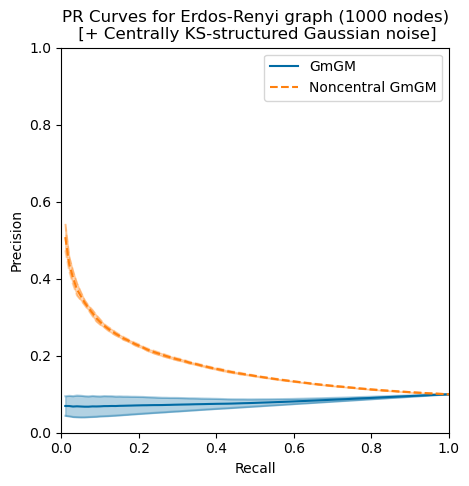

In [28]:
random.seed(SEED)
np.random.seed(SEED)

# Create a random graph
num_nodes = 1000
graph = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)
ground_truth = np.array(graph.get_adjacency().data)
colors = ["blue", "green"]

# Add diagonal so that it forms a PSD matrix!
ground_truth = ground_truth / 1.1 + np.eye(num_nodes)

fig, ax1 = plt.subplots(ncols=1, figsize=(5, 5))


algorithms = (
    [
        "GmGM",
        "GmGM + mean estimation",
        #"GmGM + nonparanormal",
        #"TeraLasso",
    ]
)
for idx, algorithm in enumerate(algorithms):
    print(f"Running {algorithm}")
    ps = []
    rs = []


    # Create a fake output
    num_trials = 10
    for i in range(num_trials):
        print(f"\tTrial {i} of {num_trials}")

        # Generate data
        output = fast_kronecker_normal(
            [ground_truth, ground_truth],
            1
        )
        # Add total mean offset
        standard_dev = 1 / np.sqrt(2 * (ground_truth[0, 0]))
        #output += np.random.normal(0, standard_dev / 10, 1)
        output += np.random.normal(0, standard_dev / 10, (num_nodes, 1))
        output += np.random.normal(0, standard_dev / 10, (1, num_nodes))
        #output += np.random.poisson(standard_dev / 10, (num_nodes, num_nodes))

        dataset = Dataset(
            dataset={"data": output},
            structure={"data": ("", "rows", "columns")}
        )
        result = None
        if algorithm == "GmGM":
            result = GmGM(
                dataset,
                to_keep=1,
                threshold_method="overall-col-weighted",
                min_edges={"rows": num_nodes - 1, "columns": num_nodes - 1},
                n_comps=None,
                verbose=False,
                centering_method=None,
                use_nonparanormal_skeptic=False,
                nonparanormal_evec_backend="COCA",
                readonly=False,
                calculate_explained_variance=True,
                batch_size=1000
            )
        elif algorithm == "GmGM + nonparanormal":
            result = GmGM(
                dataset,
                to_keep=1,
                threshold_method="overall-col-weighted",
                min_edges={"rows": num_nodes - 1, "columns": num_nodes - 1},
                n_comps=None,
                verbose=False,
                centering_method=None,
                use_nonparanormal_skeptic=True,
                nonparanormal_evec_backend="COCA",
                readonly=False,
                calculate_explained_variance=True,
                batch_size=1000
            )
        elif algorithm == "GmGM + mean estimation":
            def gmgm_estimator(data):
                output = GmGM(
                    dataset,
                    to_keep=1,
                    threshold_method="overall-col-weighted",
                    min_edges={"rows": num_nodes - 1, "columns": num_nodes - 1},
                    n_comps=None,
                    verbose=False,
                    centering_method=None,
                    use_nonparanormal_skeptic=False,
                    nonparanormal_evec_backend="COCA",
                    readonly=False,
                    calculate_explained_variance=True,
                    batch_size=1000
                )
                return output.precision_matrices
            NKS = mw.NoncentralKS(
                gmgm_estimator,
                ({axis: np.zeros(num_nodes) for axis in dataset.all_axes - dataset.batch_axes}, 0),
                {axis: np.eye(num_nodes) for axis in dataset.all_axes - dataset.batch_axes},
            )
            class result_container:
                # Jerry-rigged class to hold the result
                def __init__(self, precmats):
                    self.precision_matrices = precmats

            means, precisions = NKS.fit(dataset, verbose=True, tol=1e-1)
            result = result_container(precisions)
        elif algorithm == "TeraLasso":
            result = bg.TeraLasso(
                dataset,
                0,
                use_nonparanormal_skeptic=False
            )
        if result is None:
            raise Exception("Unknown algorithm")

        ys, xs = pr_curve(ground_truth, result.precision_matrices["columns"].toarray())
        ps.append(ys)
        rs.append(xs)
        #ax.plot(xs, ys)


    num_points = 100
    xs = np.linspace(0, 1, num_points)

    if algorithm == "GmGM":
        label = "GmGM"
    elif algorithm == "GmGM + mean estimation":
        label = "Noncentral GmGM"
    elif algorithm == "TeraLasso":
        label = "TeraLasso"
    elif algorithm == "GmGM + nonparanormal":
        label = "Nonparanormal GmGM"

    lineplot = ax1.plot(-1, -1)#, label=label)
    xs = np.linspace(0.01, 1, 100)
    min_ys = np.zeros(100) + 1
    max_ys = np.zeros(100)
    for p, r in zip(ps, rs):
        f = scipy.interpolate.interp1d(r, p, kind='linear', fill_value='extrapolate')
        min_ys = np.minimum(min_ys, f(xs))
        max_ys = np.maximum(max_ys, f(xs))
        #plt.plot(xs, f(xs), color='black', alpha=0.1)

    ax1.plot(
        xs,
        min_ys,
        color=lineplot[0].get_color(),
        linestyle=lines[idx],
        alpha=0.3
    )
    ax1.plot(
        xs,
        max_ys,
        color=lineplot[0].get_color(),
        linestyle=lines[idx],
        alpha=0.3
    )
    ax1.plot(
        xs,
        (min_ys + max_ys) / 2,
        color=lineplot[0].get_color(),
        label=label,
        linestyle=lines[idx]
    )
    ax1.fill_between(
        xs,
        min_ys,
        max_ys,
        color=lineplot[0].get_color(),
        alpha=0.3
    )#, hatch=hatches[idx]+hatches[idx])

ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title(
    f'PR Curves for Erdos-Renyi graph ({num_nodes} nodes)'
    + '\n [+ Centrally KS-structured Gaussian noise]'
)
ax1.legend()


fig.savefig('./out-figs/central-random-ks-pr-1000.pdf', bbox_inches="tight")
pass

In [ ]:
up

Running GmGM
	Trial 0 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:229: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
Running GmGM + mean estimation
	Trial 0 of 10
Iteration: 1 (Change: 44.948031464432916)
Iteration: 2 (Change: 98.1210837196191)
Iteration: 3 (Change: 0.433312195788103)
Converged in 4 iterations
Iteration: 4 (Change: 0.008706756497658041)
	Trial 1 of 10
Iteration: 1 (Change: 44.948360873593415)
Iteration: 2 (Change: 98.12266119824207)
Iteration: 3 (Change: 0.431037239444073)
Converged in 4 iterations
Iteration: 4 (Change: 0.0021488256380718233)
	Trial 2 of 10
Iteration: 1 (Change: 44.94830433777742)
Iteration: 2 (Change: 98.15237476431734)
Iteration: 3 (Change: 0.4497642853415269)
Converged in 4 iterations
Iteration: 4 (Change: 0.0021737581969096267)
	Trial 3 of 10
Iteration: 1 (Change: 44.94832981400217)
Iteration: 2 (Change: 98.22108154248252)
Iteration: 3 (Change: 0.4440548017882858)
Converged in 4 iterations
Iteration: 4 (Change: 0.00244773281581119

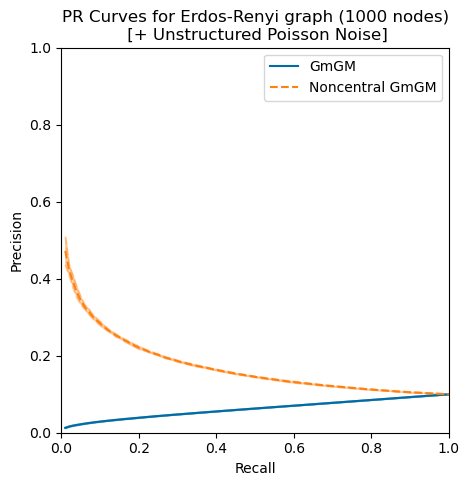

In [24]:
random.seed(SEED)
np.random.seed(SEED)

# Create a random graph
num_nodes = 1000
graph = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)
ground_truth = np.array(graph.get_adjacency().data)
colors = ["blue", "green"]

# Add diagonal so that it forms a PSD matrix!
ground_truth = ground_truth / 1.1 + np.eye(num_nodes)

fig, ax1 = plt.subplots(ncols=1, figsize=(5, 5))


algorithms = (
    [
        "GmGM",
        "GmGM + mean estimation",
        #"GmGM + nonparanormal",
        #"TeraLasso",
    ]
)
for idx, algorithm in enumerate(algorithms):
    print(f"Running {algorithm}")
    ps = []
    rs = []


    # Create a fake output
    num_trials = 10
    for i in range(num_trials):
        print(f"\tTrial {i} of {num_trials}")

        # Generate data
        output = fast_kronecker_normal(
            [ground_truth, ground_truth],
            1
        )
        # Add total mean offset
        variance = 1 / 2 * (ground_truth[0, 0])
        #output += np.random.normal(0, standard_dev / 10, 1)
        #output += np.random.normal(0, standard_dev / 10, (num_nodes, num_nodes))
        output += np.random.poisson(10 * variance, (num_nodes, num_nodes)) / 100

        dataset = Dataset(
            dataset={"data": output},
            structure={"data": ("", "rows", "columns")}
        )
        result = None
        if algorithm == "GmGM":
            result = GmGM(
                dataset,
                to_keep=1,
                threshold_method="overall-col-weighted",
                min_edges={"rows": num_nodes - 1, "columns": num_nodes - 1},
                n_comps=None,
                verbose=False,
                centering_method=None,
                use_nonparanormal_skeptic=False,
                nonparanormal_evec_backend="COCA",
                readonly=False,
                calculate_explained_variance=True,
                batch_size=1000
            )
        elif algorithm == "GmGM + nonparanormal":
            result = GmGM(
                dataset,
                to_keep=1,
                threshold_method="overall-col-weighted",
                min_edges={"rows": num_nodes - 1, "columns": num_nodes - 1},
                n_comps=None,
                verbose=False,
                centering_method=None,
                use_nonparanormal_skeptic=True,
                nonparanormal_evec_backend="COCA",
                readonly=False,
                calculate_explained_variance=True,
                batch_size=1000
            )
        elif algorithm == "GmGM + mean estimation":
            def gmgm_estimator(data):
                output = GmGM(
                    dataset,
                    to_keep=1,
                    threshold_method="overall-col-weighted",
                    min_edges={"rows": num_nodes - 1, "columns": num_nodes - 1},
                    n_comps=None,
                    verbose=False,
                    centering_method=None,
                    use_nonparanormal_skeptic=False,
                    nonparanormal_evec_backend="COCA",
                    readonly=False,
                    calculate_explained_variance=True,
                    batch_size=1000
                )
                return output.precision_matrices
            NKS = mw.NoncentralKS(
                gmgm_estimator,
                ({axis: np.zeros(num_nodes) for axis in dataset.all_axes - dataset.batch_axes}, 0),
                {axis: np.eye(num_nodes) for axis in dataset.all_axes - dataset.batch_axes},
            )
            class result_container:
                # Jerry-rigged class to hold the result
                def __init__(self, precmats):
                    self.precision_matrices = precmats

            means, precisions = NKS.fit(dataset, verbose=True, tol=1e-1, max_iter=10)
            result = result_container(precisions)
        elif algorithm == "TeraLasso":
            result = bg.TeraLasso(
                dataset,
                0,
                use_nonparanormal_skeptic=False
            )
        if result is None:
            raise Exception("Unknown algorithm")

        ys, xs = pr_curve(ground_truth, result.precision_matrices["columns"].toarray())
        ps.append(ys)
        rs.append(xs)
        #ax.plot(xs, ys)


    num_points = 100
    xs = np.linspace(0, 1, num_points)

    if algorithm == "GmGM":
        label = "GmGM"
    elif algorithm == "GmGM + mean estimation":
        label = "Noncentral GmGM"
    elif algorithm == "TeraLasso":
        label = "TeraLasso"
    elif algorithm == "GmGM + nonparanormal":
        label = "Nonparanormal GmGM"

    lineplot = ax1.plot(-1, -1)#, label=label)
    xs = np.linspace(0.01, 1, 100)
    min_ys = np.zeros(100) + 1
    max_ys = np.zeros(100)
    for p, r in zip(ps, rs):
        f = scipy.interpolate.interp1d(r, p, kind='linear', fill_value='extrapolate')
        min_ys = np.minimum(min_ys, f(xs))
        max_ys = np.maximum(max_ys, f(xs))
        #plt.plot(xs, f(xs), color='black', alpha=0.1)

    ax1.plot(
        xs,
        min_ys,
        color=lineplot[0].get_color(),
        linestyle=lines[idx],
        alpha=0.3
    )
    ax1.plot(
        xs,
        max_ys,
        color=lineplot[0].get_color(),
        linestyle=lines[idx],
        alpha=0.3
    )
    ax1.plot(
        xs,
        (min_ys + max_ys) / 2,
        color=lineplot[0].get_color(),
        label=label,
        linestyle=lines[idx]
    )
    ax1.fill_between(
        xs,
        min_ys,
        max_ys,
        color=lineplot[0].get_color(),
        alpha=0.3
    )#, hatch=hatches[idx]+hatches[idx])

ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title(
    f'PR Curves for Erdos-Renyi graph ({num_nodes} nodes)'
    + '\n [+ Unstructured Poisson Noise]'
)
ax1.legend()


fig.savefig('./out-figs/random-ks-pr-1000.pdf', bbox_inches="tight")
pass

Running GmGM
	Trial 0 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:229: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
Running GmGM + mean estimation
	Trial 0 of 10
Iteration: 1 (Change: 110.14185952358874)
Iteration: 2 (Change: 2.913422869725673)
Converged in 3 iterations
Iteration: 3 (Change: 0.014510299607931602)
	Trial 1 of 10
Iteration: 1 (Change: 110.13392250321475)
Iteration: 2 (Change: 2.916793239208595)
Converged in 3 iterations
Iteration: 3 (Change: 0.011983633001062756)
	Trial 2 of 10
Iteration: 1 (Change: 110.23198369504482)
Iteration: 2 (Change: 3.009783052249189)
Converged in 3 iterations
Iteration: 3 (Change: 0.010715581038609234)
	Trial 3 of 10
Iteration: 1 (Change: 110.11938185175798)
Iteration: 2 (Change: 2.923777078451772)
Converged in 3 iterations
Iteration: 3 (Change: 0.010450796559400136)
	Trial 4 of 10
Iteration: 1 (Change: 110.19677262623732)
Iteration: 2 (Change: 2.983022732966802)
Converged in 3 iterations
Iteration: 3 (Change: 0.01183393704775

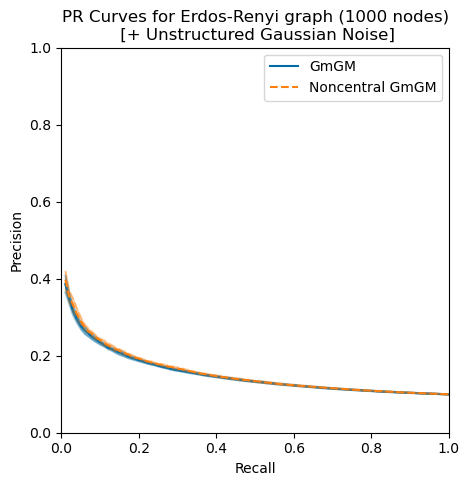

In [27]:
random.seed(SEED)
np.random.seed(SEED)

# Create a random graph
num_nodes = 1000
graph = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)
ground_truth = np.array(graph.get_adjacency().data)
colors = ["blue", "green"]

# Add diagonal so that it forms a PSD matrix!
ground_truth = ground_truth / 1.1 + np.eye(num_nodes)

fig, ax1 = plt.subplots(ncols=1, figsize=(5, 5))


algorithms = (
    [
        "GmGM",
        "GmGM + mean estimation",
        #"GmGM + nonparanormal",
        #"TeraLasso",
    ]
)
for idx, algorithm in enumerate(algorithms):
    print(f"Running {algorithm}")
    ps = []
    rs = []


    # Create a fake output
    num_trials = 10
    for i in range(num_trials):
        print(f"\tTrial {i} of {num_trials}")

        # Generate data
        output = fast_kronecker_normal(
            [ground_truth, ground_truth],
            1
        )
        # Add total mean offset
        standard_dev = 1 / np.sqrt(2 * (ground_truth[0, 0]))
        #output += np.random.normal(0, standard_dev / 10, 1)
        #output += np.random.normal(0, standard_dev / 10, (num_nodes, num_nodes))
        output += np.random.normal(0, standard_dev / 10, (num_nodes, num_nodes))

        dataset = Dataset(
            dataset={"data": output},
            structure={"data": ("", "rows", "columns")}
        )
        result = None
        if algorithm == "GmGM":
            result = GmGM(
                dataset,
                to_keep=1,
                threshold_method="overall-col-weighted",
                min_edges={"rows": num_nodes - 1, "columns": num_nodes - 1},
                n_comps=None,
                verbose=False,
                centering_method=None,
                use_nonparanormal_skeptic=False,
                nonparanormal_evec_backend="COCA",
                readonly=False,
                calculate_explained_variance=True,
                batch_size=1000
            )
        elif algorithm == "GmGM + nonparanormal":
            result = GmGM(
                dataset,
                to_keep=1,
                threshold_method="overall-col-weighted",
                min_edges={"rows": num_nodes - 1, "columns": num_nodes - 1},
                n_comps=None,
                verbose=False,
                centering_method=None,
                use_nonparanormal_skeptic=True,
                nonparanormal_evec_backend="COCA",
                readonly=False,
                calculate_explained_variance=True,
                batch_size=1000
            )
        elif algorithm == "GmGM + mean estimation":
            def gmgm_estimator(data):
                output = GmGM(
                    dataset,
                    to_keep=1,
                    threshold_method="overall-col-weighted",
                    min_edges={"rows": num_nodes - 1, "columns": num_nodes - 1},
                    n_comps=None,
                    verbose=False,
                    centering_method=None,
                    use_nonparanormal_skeptic=False,
                    nonparanormal_evec_backend="COCA",
                    readonly=False,
                    calculate_explained_variance=True,
                    batch_size=1000
                )
                return output.precision_matrices
            NKS = mw.NoncentralKS(
                gmgm_estimator,
                ({axis: np.zeros(num_nodes) for axis in dataset.all_axes - dataset.batch_axes}, 0),
                {axis: np.eye(num_nodes) for axis in dataset.all_axes - dataset.batch_axes},
            )
            class result_container:
                # Jerry-rigged class to hold the result
                def __init__(self, precmats):
                    self.precision_matrices = precmats

            means, precisions = NKS.fit(dataset, verbose=True, tol=1e-1, max_iter=10)
            result = result_container(precisions)
        elif algorithm == "TeraLasso":
            result = bg.TeraLasso(
                dataset,
                0,
                use_nonparanormal_skeptic=False
            )
        if result is None:
            raise Exception("Unknown algorithm")

        ys, xs = pr_curve(ground_truth, result.precision_matrices["columns"].toarray())
        ps.append(ys)
        rs.append(xs)
        #ax.plot(xs, ys)


    num_points = 100
    xs = np.linspace(0, 1, num_points)

    if algorithm == "GmGM":
        label = "GmGM"
    elif algorithm == "GmGM + mean estimation":
        label = "Noncentral GmGM"
    elif algorithm == "TeraLasso":
        label = "TeraLasso"
    elif algorithm == "GmGM + nonparanormal":
        label = "Nonparanormal GmGM"

    lineplot = ax1.plot(-1, -1)#, label=label)
    xs = np.linspace(0.01, 1, 100)
    min_ys = np.zeros(100) + 1
    max_ys = np.zeros(100)
    for p, r in zip(ps, rs):
        f = scipy.interpolate.interp1d(r, p, kind='linear', fill_value='extrapolate')
        min_ys = np.minimum(min_ys, f(xs))
        max_ys = np.maximum(max_ys, f(xs))
        #plt.plot(xs, f(xs), color='black', alpha=0.1)

    ax1.plot(
        xs,
        min_ys,
        color=lineplot[0].get_color(),
        linestyle=lines[idx],
        alpha=0.3
    )
    ax1.plot(
        xs,
        max_ys,
        color=lineplot[0].get_color(),
        linestyle=lines[idx],
        alpha=0.3
    )
    ax1.plot(
        xs,
        (min_ys + max_ys) / 2,
        color=lineplot[0].get_color(),
        label=label,
        linestyle=lines[idx]
    )
    ax1.fill_between(
        xs,
        min_ys,
        max_ys,
        color=lineplot[0].get_color(),
        alpha=0.3
    )#, hatch=hatches[idx]+hatches[idx])

ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title(
    f'PR Curves for Erdos-Renyi graph ({num_nodes} nodes)'
    + '\n [+ Unstructured Gaussian Noise]'
)
ax1.legend()


fig.savefig('./out-figs/random-gauss-ks-pr-1000.pdf', bbox_inches="tight")
pass